### Download datasets for this model here:

* https://drive.google.com/drive/folders/19TuTEOKfSOWr4IVf9PrTnN2TQiogoyYV?usp=sharing 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
%matplotlib inline

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

 ### Here we deifne how to tansform the the data to fit our models
 
 * With the torchvision transformer function
 * We will randomly flip images horisontally for Data augmentaion with we hope to imporve our accuracy
 * We then transform the dataset into a Tensor.
 * Therafter normalize the data.

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### We also have a transform function for our validation set

In [3]:
valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### We define the training and test sets.

* Here we tell torchvision where the data is, then we load in the data with the DataLoader function
* we also split the data into a training set and a test set by using the train perameters, True or false

In [4]:
dataset = torchvision.datasets.CIFAR10(root='datasets/', download=True, transform=ToTensor())

train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)




  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets/
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Here we import the Pyplot to assess if the images are loaded correctly or not.

* Importing matplotlip and numpy.
* We define a function to show images from the train_loader dataset
* We create a grid with torchvision and imbed the images into the grid.

In [5]:
len(validation_set), len(test_set), len(train_set)

(10000, 10000, 50000)

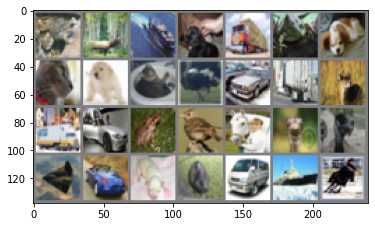

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:28], nrow=7))

### Check how many images the training and testing datasets contain

In [7]:
dataset_size = len(train_set)
test_dataset_size = len(test_set)

print("Training dataset size", dataset_size)
print("Testing datasets size", test_dataset_size)

print(dataset)


Training dataset size 50000
Testing datasets size 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()


### Get the classes of the entire dataset

In [8]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Get the Shapes of the images

In [9]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

### Print a sample image

Label (numeric): 6
Label (textual): frog


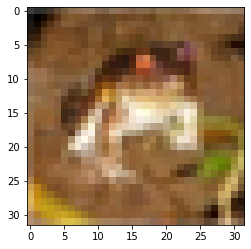

In [10]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

### Here we determine the number of images belonging to each class?

* We define the length of the dataset
* We then check hoe many classes there are
* We create a dictionary to store the values
* we then do 2 for loops, first to get the classes and the second to count the amount of images retaining to the classes 

In [11]:
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


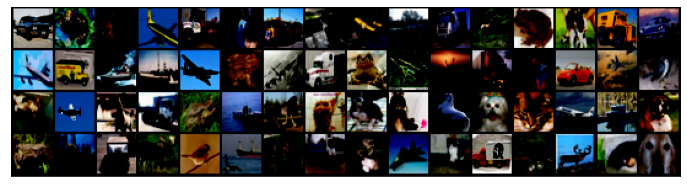

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

### Here we are creating the functionality for calculating the models accuracy

* Todo = Find out how this function works

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### ImageClassificationBase contains 4 functions
* One function is for training and validation sets, which implement the loss and accuracy.
* The validation_epoch_end combines the losses and accuracy for each epock 
* The epoch_end prints the val_lass and val_acc at the end of each epoch

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

##### nn.Sequential chains the layres and activation functions into a single network architecture

In [15]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [16]:
print(Cifar10CnnModel)

<class '__main__.Cifar10CnnModel'>


### Here we move our model to GPU if it can run it

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print("Model will run on, GPU")
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')


In [18]:
device = get_default_device()
device

Model will run on, GPU


device(type='cuda')

#### Here we load the data into the GPU device

In [19]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [21]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [22]:
model = to_device(model, device)

### The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(model, validation_loader)]
history

[{'val_acc': 0.09982085973024368, 'val_loss': 2.3029282093048096}]

### Here we define the input and output size

In [25]:
input_size = 3*32*32
output_size = 10

### Number of epochs to cycle through and the learning rate is set here

In [26]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

### The fit function will record validation loss and metrics for each epoch

In [27]:
history += fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

Epoch [0], train_loss: 1.6043, val_loss: 1.2330, val_acc: 0.5441
Epoch [1], train_loss: 1.0874, val_loss: 0.9226, val_acc: 0.6771
Epoch [2], train_loss: 0.8407, val_loss: 0.7835, val_acc: 0.7270
Epoch [3], train_loss: 0.7020, val_loss: 0.7625, val_acc: 0.7412
Epoch [4], train_loss: 0.6040, val_loss: 0.6652, val_acc: 0.7807
Epoch [5], train_loss: 0.5315, val_loss: 0.6916, val_acc: 0.7688
Epoch [6], train_loss: 0.4811, val_loss: 0.6475, val_acc: 0.7873
Epoch [7], train_loss: 0.4335, val_loss: 0.6420, val_acc: 0.7944
Epoch [8], train_loss: 0.3884, val_loss: 0.6445, val_acc: 0.7956
Epoch [9], train_loss: 0.3563, val_loss: 0.6490, val_acc: 0.8048


### These functions will plot the losses and accuracy of the history i.e. the training

In [28]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs'); 

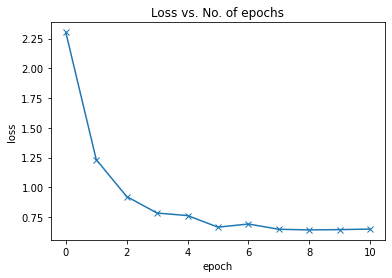

In [29]:
plot_losses(history)

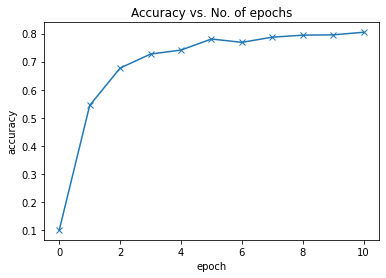

In [30]:
plot_accuracies(history)

### this function will plot will plott the loss difference between the validation set and the training setmm

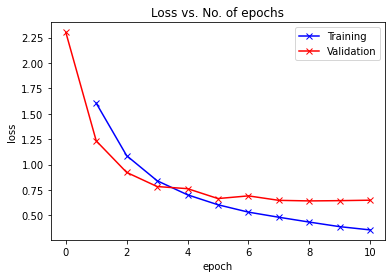

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
plot_losses(history);

### Get the accuraccy results for each class

In [32]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_actual = []
y_pred = []
confusion_matrix = np.zeros([10,10], int)

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_actual.append(label)
            y_pred.append(prediction)
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predictions[i].item()] += 1 

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane is: 79.8 %
Accuracy for class automobile is: 84.7 %
Accuracy for class bird  is: 74.3 %
Accuracy for class cat   is: 66.2 %
Accuracy for class deer  is: 72.9 %
Accuracy for class dog   is: 78.0 %
Accuracy for class frog  is: 84.9 %
Accuracy for class horse is: 84.6 %
Accuracy for class ship  is: 88.5 %
Accuracy for class truck is: 92.0 %


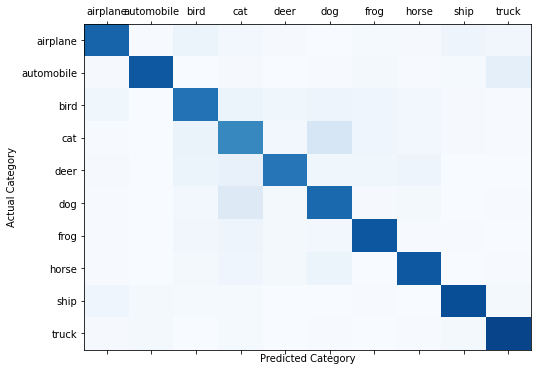

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [34]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     airplane  automobilebird      cat       deer      dog       frog      horse     ship      truck     
airplane        798       6         51        31        8         3         14        8         47        34        
                0.798     0.006     0.051     0.031     0.008     0.003     0.014     0.008     0.047     0.034     
automobile      10        847       3         8         1         6         19        5         13        88        
                0.01      0.847     0.003     0.008     0.001     0.006     0.019     0.005     0.013     0.088     
bird            36        0         743       52        36        48        44        27        10        4         
                0.036     0.0       0.743     0.052     0.036     0.048     0.044     0.027     0.01      0.004     
cat             5         1         66        662       28        160       42        24        8         4         
                0.005     0.001     0.066     0.662     0.028   

In [35]:
TP = 0
FP = 0
FN = 0

for i,r in enumerate(confusion_matrix):
    total = 0
    thisTP = 0
    thisFN = 0
    thisFP = 0 
    for i3 in range (0,10):
        if (i != i3):
            thisFP += confusion_matrix[i3][i]
    for i2,r2 in enumerate(r):
        total += r2
        if (i == i2):
            thisTP += r2
        else:
            thisFN += r2
    
    print(classes[i])
    print('True positives %d' % (thisTP))
    print('False positives %d' % (thisFP))
    print('False negatives %d' % (thisFN))
    precision = thisTP / (thisTP + thisFP)
    recall = thisTP / (thisTP + thisFN)
    print('Precicion {}'.format(precision))
    print('Recall {}'.format(recall))
    f1 = (2 * (precision*recall)) / (precision + recall)
    print('F1 {}'.format(f1))

airplane
True positives 798
False positives 128
False negatives 202
Precicion 0.8617710583153347
Recall 0.798
F1 0.8286604361370716
automobile
True positives 847
False positives 46
False negatives 153
Precicion 0.948488241881299
Recall 0.847
F1 0.8948758584257792
bird
True positives 743
False positives 278
False negatives 257
Precicion 0.7277179236043095
Recall 0.743
F1 0.7352795645719941
cat
True positives 662
False positives 420
False negatives 338
Precicion 0.6118299445471349
Recall 0.662
F1 0.6359269932756965
deer
True positives 729
False positives 133
False negatives 271
Precicion 0.845707656612529
Recall 0.729
F1 0.7830290010741139
dog
True positives 780
False positives 341
False negatives 220
Precicion 0.695807314897413
Recall 0.78
F1 0.7355021216407354
frog
True positives 849
False positives 177
False negatives 151
Precicion 0.827485380116959
Recall 0.849
F1 0.8381046396841065
horse
True positives 846
False positives 147
False negatives 154
Precicion 0.851963746223565
Recall 0.